In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import os
import numpy as np
from Classification.cnn1D_model import VibrationDataset, CNN1D_DS
from Classification.cnn1D_model import train_and_evaluate, train_and_evaluate_with_kfold
import torch
from torch.utils.data import Dataset, DataLoader, random_split,Subset
from sklearn.model_selection import train_test_split
import random
import pandas as pd
from utils.baseline_xai import predict_single, summarize_attributions
from utils.baseline_xai import grad_times_input_relevance, smoothgrad_relevance, occlusion_signal_relevance, occlusion_simpler_relevance
from  visualization.relevance_visualization import visualize_with_label_attribution, visualize_lrp_single_sample, visualize_lrp_dft, visualize_lrp_fft
from utils.xai_implementation import compute_lrp_relevance, compute_dft_lrp_relevance, compute_fft_lrp_relevance
from sklearn.model_selection import GroupKFold
from collections import Counter

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [52]:
# Load dataset
data_directory = "../data/final/new_selection/normalized_windowed_data"
dataset = VibrationDataset(data_directory, augment_bad=False)

# Create a combined stratification key (label_operation)
stratify_key = [f"{lbl}_{op}" for lbl, op in zip(dataset.labels, dataset.operations)]

# Stratified split by both label and operation
train_idx, temp_idx = train_test_split(
    range(len(dataset)), test_size=0.3, stratify=stratify_key
)
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, stratify=[stratify_key[i] for i in temp_idx]
)

# Create Subset datasets
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

# Verify split sizes and label distribution
print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")
print(f"Train good: {sum(dataset.labels[train_idx] == 0)}, Train bad: {sum(dataset.labels[train_idx] == 1)}")
print(f"Val good: {sum(dataset.labels[val_idx] == 0)}, Val bad: {sum(dataset.labels[val_idx] == 1)}")
print(f"Test good: {sum(dataset.labels[test_idx] == 0)}, Test bad: {sum(dataset.labels[test_idx] == 1)}")

# Class ratios
train_ratio = sum(dataset.labels[train_idx] == 0) / sum(dataset.labels[train_idx] == 1)
val_ratio = sum(dataset.labels[val_idx] == 0) / sum(dataset.labels[val_idx] == 1)
test_ratio = sum(dataset.labels[test_idx] == 0) / sum(dataset.labels[test_idx] == 1)
print(f"Class ratio (good/bad) - Train: {train_ratio:.2f}, Val: {val_ratio:.2f}, Test: {test_ratio:.2f}")

# Operation distribution
train_ops = Counter(dataset.operations[train_idx])
val_ops = Counter(dataset.operations[val_idx])
test_ops = Counter(dataset.operations[test_idx])
print(f"Train operations: {train_ops}")
print(f"Val operations: {val_ops}")
print(f"Test operations: {test_ops}")

# Creating DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train size: 5250, Val size: 1125, Test size: 1126
Train good: 3924, Train bad: 1326
Val good: 839, Val bad: 286
Test good: 843, Test bad: 283
Class ratio (good/bad) - Train: 2.96, Val: 2.93, Test: 2.98
Train operations: Counter({np.str_('OP06'): 806, np.str_('OP04'): 694, np.str_('OP10'): 568, np.str_('OP12'): 559, np.str_('OP02'): 551, np.str_('OP11'): 534, np.str_('OP08'): 442, np.str_('OP14'): 330, np.str_('OP01'): 321, np.str_('OP07'): 279, np.str_('OP05'): 166})
Val operations: Counter({np.str_('OP06'): 173, np.str_('OP04'): 148, np.str_('OP10'): 121, np.str_('OP12'): 120, np.str_('OP02'): 119, np.str_('OP11'): 114, np.str_('OP08'): 94, np.str_('OP14'): 71, np.str_('OP01'): 69, np.str_('OP07'): 60, np.str_('OP05'): 36})
Test operations: Counter({np.str_('OP06'): 173, np.str_('OP04'): 149, np.str_('OP10'): 122, np.str_('OP12'): 119, np.str_('OP02'): 118, np.str_('OP11'): 115, np.str_('OP08'): 95, np.str_('OP14'): 71, np.str_('OP01'): 69, np.str_('OP07'): 60, np.str_('OP05'): 35})


Using device: cuda
Epoch [1/20] - Train Loss: 0.5053, Train Acc: 0.7522 - Val Loss: 0.2870, Val Acc: 0.9182 
Epoch [2/20] - Train Loss: 0.1580, Train Acc: 0.9503 - Val Loss: 0.0959, Val Acc: 0.9609 
Epoch [3/20] - Train Loss: 0.0632, Train Acc: 0.9756 - Val Loss: 0.0302, Val Acc: 0.9929 
Epoch [4/20] - Train Loss: 0.0279, Train Acc: 0.9926 - Val Loss: 0.0287, Val Acc: 0.9893 
Epoch [5/20] - Train Loss: 0.0207, Train Acc: 0.9939 - Val Loss: 0.0137, Val Acc: 0.9956 
Epoch [6/20] - Train Loss: 0.0207, Train Acc: 0.9943 - Val Loss: 0.0090, Val Acc: 0.9973 
Epoch [7/20] - Train Loss: 0.0121, Train Acc: 0.9962 - Val Loss: 0.0840, Val Acc: 0.9662 
Epoch [8/20] - Train Loss: 0.0149, Train Acc: 0.9956 - Val Loss: 0.0099, Val Acc: 0.9973 
Epoch [9/20] - Train Loss: 0.0110, Train Acc: 0.9962 - Val Loss: 0.0094, Val Acc: 0.9973 
Epoch [10/20] - Train Loss: 0.0165, Train Acc: 0.9943 - Val Loss: 0.0369, Val Acc: 0.9867 
Epoch [11/20] - Train Loss: 0.0183, Train Acc: 0.9943 - Val Loss: 0.0038, Val Ac

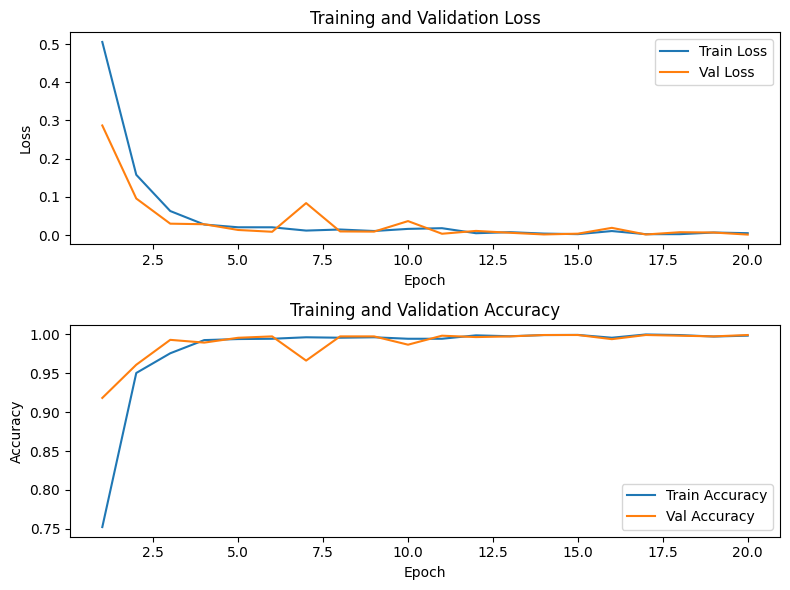

In [53]:
# ------------------------
#  Run Training & Evaluation
# ------------------------
# model = train_and_evaluate(train_loader, val_loader, test_loader)
best_model = train_and_evaluate(train_loader, val_loader, test_loader)



In [10]:
# Save the trained model
torch.save(best_model.state_dict(), "../cnn1d_model.ckpt")
print("✅ Model saved to cnn1d_model.ckpt")
best_model.to(device)
best_model.eval()  # Switch to evaluation mode
print("✅ Model loaded and ready for explanations")
print(f"✅ Model is structured as  \n {best_model}")


✅ Model saved to cnn1d_model.ckpt
✅ Model loaded and ready for explanations
✅ Model is structured as  
 CNN1D_DS(
  (conv1): Conv1d(3, 16, kernel_size=(9,), stride=(1,))
  (gn1): GroupNorm(4, 16, eps=1e-05, affine=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(7,), stride=(1,))
  (gn2): GroupNorm(4, 32, eps=1e-05, affine=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(5,), stride=(1,))
  (gn3): GroupNorm(4, 64, eps=1e-05, affine=True)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_avg_pool): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
)


### Explain the Model

#### choose a good sample

In [29]:
# Load a Good sample

# Load a batch
sample_batch, label_batch = next(iter(test_loader))

# Choose a random index
random_index = random.randint(0, len(sample_batch) - 1)


# Select the random sample and its corresponding label
sample = sample_batch[random_index]  # Shape: (3, 10000)
label = label_batch[random_index]    # Shape: ()



sample = sample.to(device)
label = label.to(device)

_, predicted_label = predict_single(best_model, sample)


# Print the selected sample and label
print(f"Random Index: {random_index}, Predicted_label:{predicted_label}, True_label:{label}")
print(sample, sample.shape)


Random Index: 27, Predicted_label:0, True_label:0
tensor([[-0.0079, -0.0575,  0.1072,  ..., -0.5801, -0.3398, -0.2462],
        [-0.0126,  0.0722, -0.1368,  ...,  0.1669, -0.3844,  0.5266],
        [ 0.1859,  0.0525,  0.0392,  ...,  0.0251,  0.2039, -0.0383]],
       device='cuda:0') torch.Size([3, 2000])


#### DFT-LRP implementation

In [30]:
relevance_time, relevance_freq, signal_freq, input_signal, freqs, predicted_label = compute_dft_lrp_relevance(
        model=best_model,
        sample=sample.cpu().detach().numpy(),  # Convert to NumPy for DFTLRP
        label=label.item(),
        device=device,
        signal_length=2000,   #10000 if we did not downsample
        sampling_rate=400  # Placeholder, replace with your actual sampling rate     #2000 if we did not downsample
    )

Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
3
1001


E:\Thesis\Datasets\CNC\utils\dft_lrp.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=dtype)


Min relevance: -0.06167855113744736, Max relevance: 0.027387922629714012
 Maximum Absolute Attribution in Axis 0: 0.03852322697639465
 Maximum Absolute Attribution in Axis 1: 0.06167855113744736
 Maximum Absolute Attribution in Axis 2: 0.033361613750457764


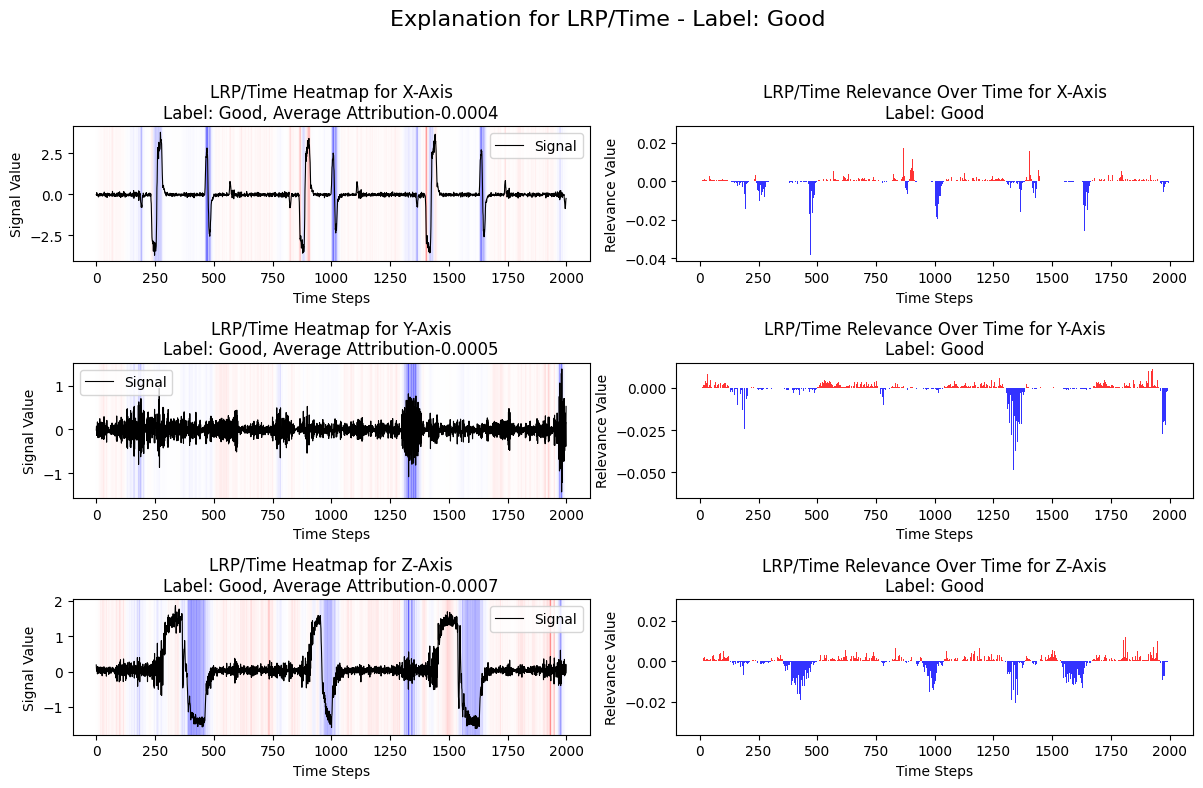

In [62]:
# LRP visualization with mutual visualization function
print(f"Min relevance: {np.min(relevance_time)}, Max relevance: {np.max(relevance_time)}")
visualize_with_label_attribution(sample, relevance_time, label, "LRP/Time")


In [63]:
""# Global Attribution over frequency with LRP
summary_lrp_freq = summarize_attributions(relevance_freq)  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_lrp_freq = []
for axis, values in summary_lrp_freq.items():
    row = {"Axis": axis}
    row.update(values)
    data_lrp_freq.append(row)

# Create the DataFrame
df_summary_lrp_freq = pd.DataFrame(data_lrp_freq)

# Display the DataFrame as a table
print(df_summary_lrp_freq)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0             548                  2.364421   
1  Axis 1             515                  1.431607   
2  Axis 2             552                  2.153831   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.004315             453                 -3.207996   
1                    0.002780             486                 -2.366088   
2                    0.003902             449                 -3.463729   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.007082                    -0.843575   
1                   -0.004868                    -0.934482   
2                   -0.007714                    -1.309898   

   Average Relevance (Pos + Neg)  
0                      -0.000843  
1                      -0.000934  
2                      -0.001309  


In [71]:
""# Global Attribution over frequency with LRP
summary_lrp_t = summarize_attributions(relevance_time)  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_lrp_t = []
for axis, values in summary_lrp_t.items():
    row = {"Axis": axis}
    row.update(values)
    data_lrp_t.append(row)

# Create the DataFrame
df_summary_lrp_t = pd.DataFrame(data_lrp_t)

# Display the DataFrame as a table
print(df_summary_lrp_t)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            1126                  1.156974   
1  Axis 1            1101                  1.666562   
2  Axis 2            1224                  1.861465   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.001028             874                 -1.986081   
1                    0.001514             899                 -2.633358   
2                    0.001521             776                 -3.216005   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.002272                    -0.829108   
1                   -0.002929                    -0.966795   
2                   -0.004144                    -1.354541   

   Average Relevance (Pos + Neg)  
0                      -0.000415  
1                      -0.000483  
2                      -0.000677  


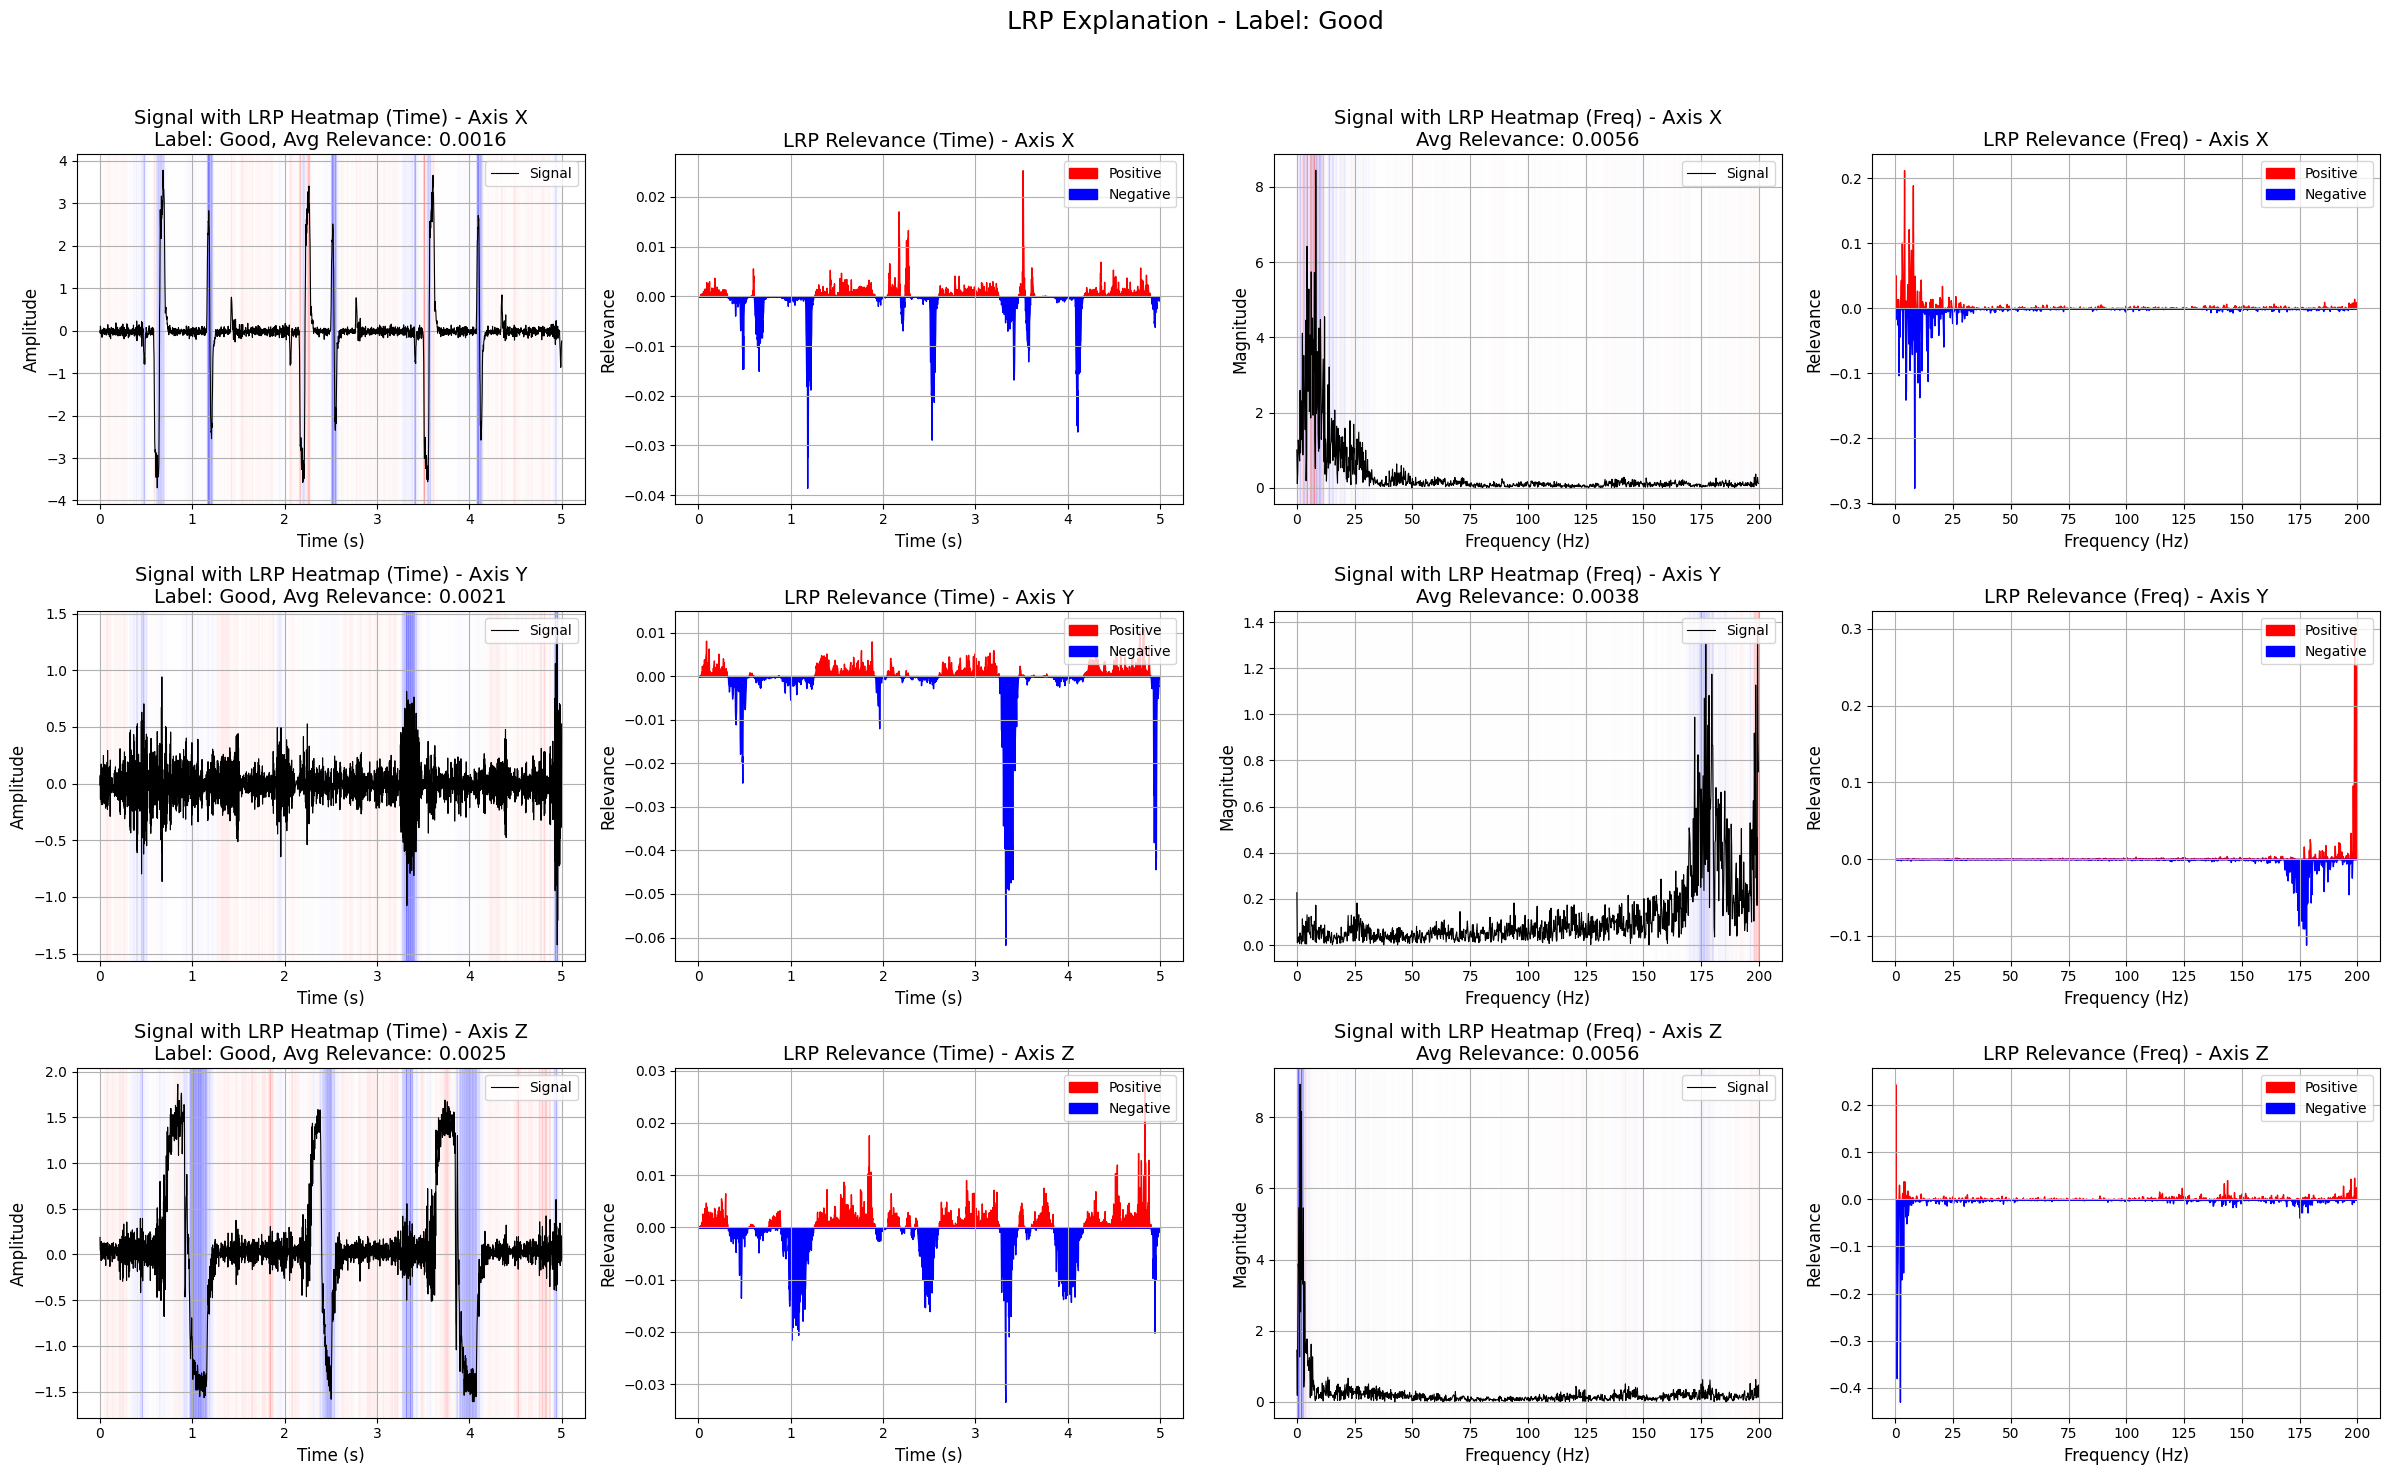

In [75]:
# Visualize the results
visualize_lrp_dft(
        relevance_time=relevance_time,
        relevance_freq=relevance_freq,
        signal_freq=signal_freq,
        input_signal=input_signal,
        freqs=freqs,
        predicted_label=predicted_label,
        k_max=1000,  # Plot up to 1000 Hz
        sampling_rate=400  # Placeholder, replace with your actual sampling rate
    )

In [ ]:
# LRP visualization with common visualization function
 # write something similar to the common visualization for the frequency, so the relevance are colored over fft/dft signals
# in compute_dft_lrp_relevance why freqs are calculated by fft not dft?

#### FFT-LRP implementation

In [80]:
relevance_time_fft, relevance_freq_fft, signal_freq_fft, relevance_timefreq_fft, signal_timefreq_fft, input_signal_fft, freqs_fft, predicted_label_fft = compute_fft_lrp_relevance(
        model=best_model,
        sample=sample,
        label=None,
        signal_length=2000,
        sampling_rate=400,
        compute_timefreq=True,
        window_shift=64,  # Increased to reduce memory usage
        window_width=128,
        window_shape="rectangle"
    )

Input sample shape: torch.Size([1, 3, 2000])
Target label: 0
Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
relevance_time_tensor shape before squeeze: (1, 3, 2000)
relevance_time shape after squeeze: (3, 2000)
input_signal shape: (3, 2000)
fft_lrp: Input relevance shape = (1, 2000), signal shape = (1, 2000)
fft_lrp: relevance_tensor shape = torch.Size([1, 2000]), signal_tensor shape = torch.Size([1, 2000])
fourier_transform: signal_tensor shape = torch.Size([1, 2000])
fourier_transform (FFT): signal_hat shape = torch.Size([1, 1001])
fft_lrp: signal_hat shape = torch.Size([1, 1001])
fft_lrp: relevance_normed shape = torch.Size([1, 2000])
fft_lrp: relevance_fft real part = tensor([[-0.0509,  0.0080, -0.0134,  ..., -0.0033,  0.0002, -0.0172]],
       device='cuda:0')
fft_lrp: relevance_fft imag part = tensor([[ 0.0000,  0.0085, -0.0243,  ..., -0.0199,  0.0061, -0.0000]],
       device='cuda:0')
fft_lrp: relevance_hat real part before cpu = tensor([[

In [81]:
# Global Attribution for FFT_LRP over frequency
summary_fft_freq = summarize_attributions(relevance_freq_fft)  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_fft_freq = []
for axis, values in summary_fft_freq.items():
    row = {"Axis": axis}
    row.update(values)
    data_fft_freq.append(row)

# Create the DataFrame
df_summary_fft_freq = pd.DataFrame(data_fft_freq)

# Display the DataFrame as a table
print(df_summary_fft_freq)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0             548        4.043233+0.000000j   
1  Axis 1             514        3.013343+0.000000j   
2  Axis 2             551        5.490004+0.000000j   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0          0.007378+0.000000j             453       -3.041981+0.000000j   
1          0.005863+0.000000j             487       -3.659343+0.000000j   
2          0.009964+0.000000j             450       -3.853632+0.000000j   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0         -0.006715+0.000000j           1.001252+0.000000j   
1         -0.007514+0.000000j          -0.646001+0.000000j   
2         -0.008564+0.000000j           1.636372+0.000000j   

   Average Relevance (Pos + Neg)  
0             0.001000+0.000000j  
1            -0.000645+0.000000j  
2             0.001635+0.000000j  


In [65]:
# Global Attribution for FFT_LRP over time frequency
summary_fft_timefreq = summarize_attributions(relevance_timefreq_fft)  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_fft_timefreq = []
for axis, values in summary_fft_timefreq.items():
    row = {"Axis": axis}
    row.update(values)
    data_fft_timefreq.append(row)

# Create the DataFrame
df_summary_fft_timefreq = pd.DataFrame(data_fft_timefreq)

# Display the DataFrame as a table
print(df_summary_fft_timefreq)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0           11096  1005.736262+   0.000000j   
1  Axis 1           11154   888.735683+   0.000000j   
2  Axis 2           11356  1432.685977+   0.000000j   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0          0.090640+0.000000j            8924   -474.175903+  0.000000j   
1          0.079679+0.000000j            8866   -476.783394+  0.000000j   
2          0.126161+0.000000j            8664   -546.809428+  0.000000j   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0         -0.053135+0.000000j       531.560359+  0.000000j   
1         -0.053777+0.000000j       411.952290+  0.000000j   
2         -0.063113+0.000000j       885.876549+  0.000000j   

   Average Relevance (Pos + Neg)  
0             0.026551+0.000000j  
1             0.020577+0.000000j  
2             0.044250+0.000000j  


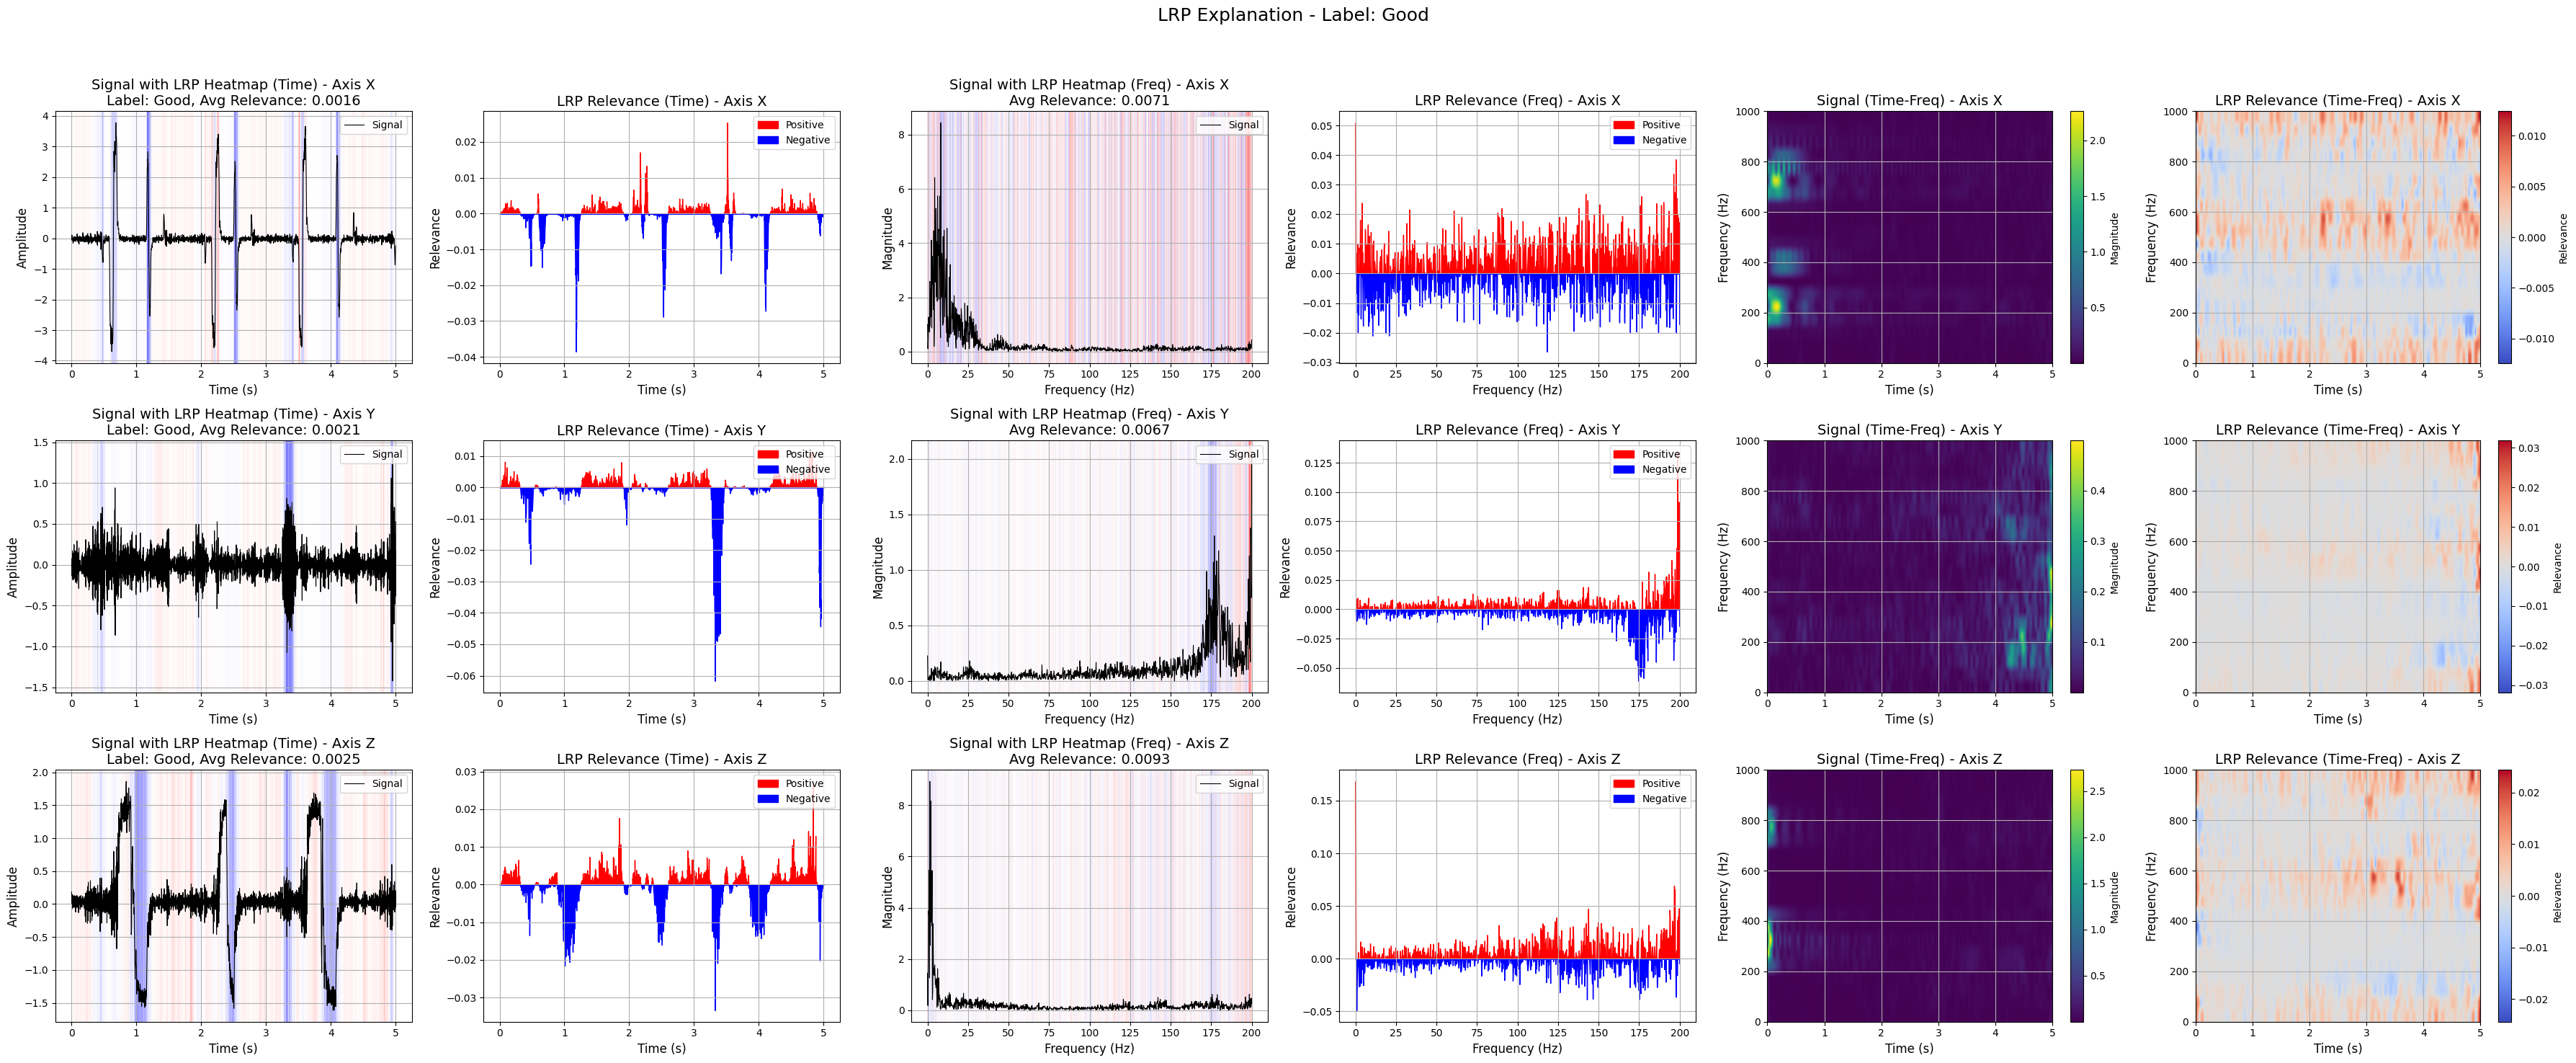

In [83]:
# Visualize
visualize_lrp_fft(
    relevance_time=relevance_time_fft,
    relevance_freq=relevance_freq_fft,
    signal_freq=signal_freq_fft,
    relevance_timefreq=relevance_timefreq_fft,
    signal_timefreq=signal_timefreq_fft,
    input_signal=input_signal_fft,
    freqs=freqs_fft,
    predicted_label=predicted_label_fft,
    signal_length=2000,
    sampling_rate=400,
    k_max=1000
)

Min relevance: -0.018034230917692184, Max relevance: 0.009351301938295364
 Maximum Absolute Attribution in Axis 0: 0.007959180511534214
 Maximum Absolute Attribution in Axis 1: 0.008765474893152714
 Maximum Absolute Attribution in Axis 2: 0.018034230917692184


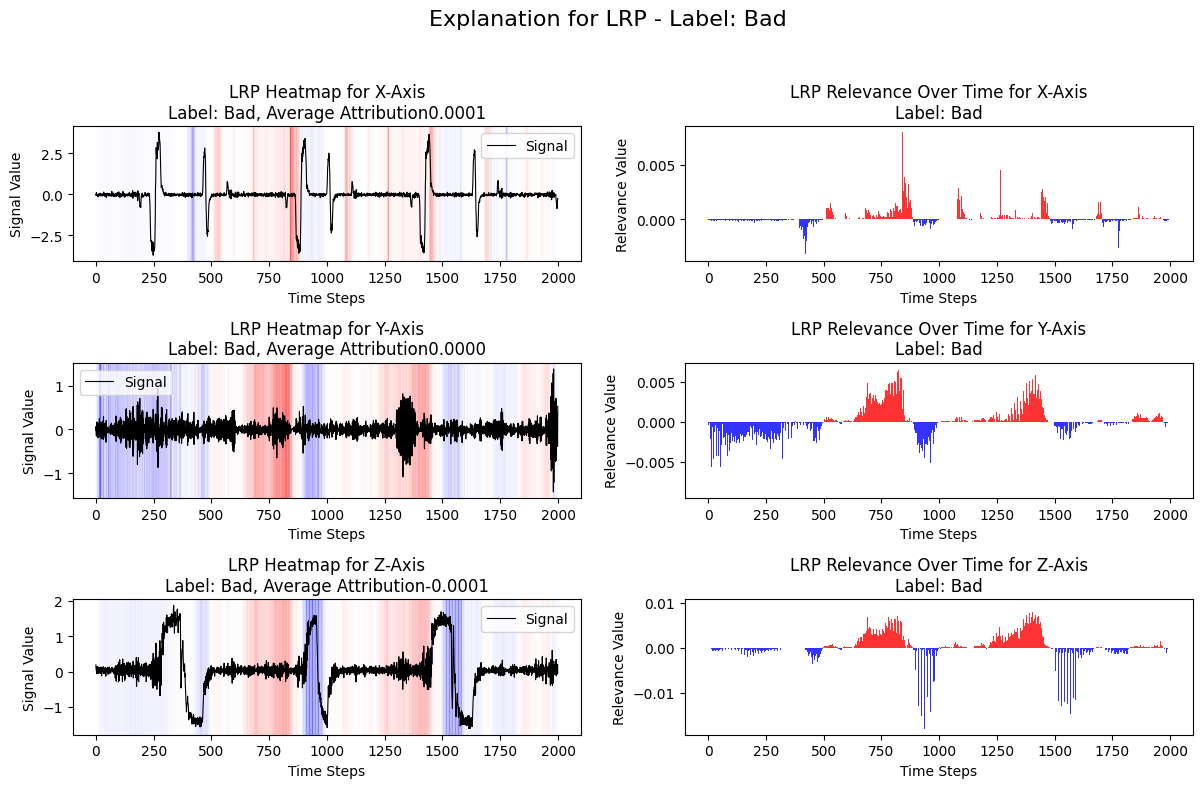

In [43]:

print(f"Min relevance: {np.min(relevance_b)}, Max relevance: {np.max(relevance_b)}")
visualize_with_label_attribution(sample, relevance_b, label_b, "LRP")


Min relevance: -0.042411595582962036, Max relevance: 0.060619376599788666
 Maximum Absolute Attribution in Axis 0: 0.060619376599788666
 Maximum Absolute Attribution in Axis 1: 0.042411595582962036
 Maximum Absolute Attribution in Axis 2: 0.025282150134444237


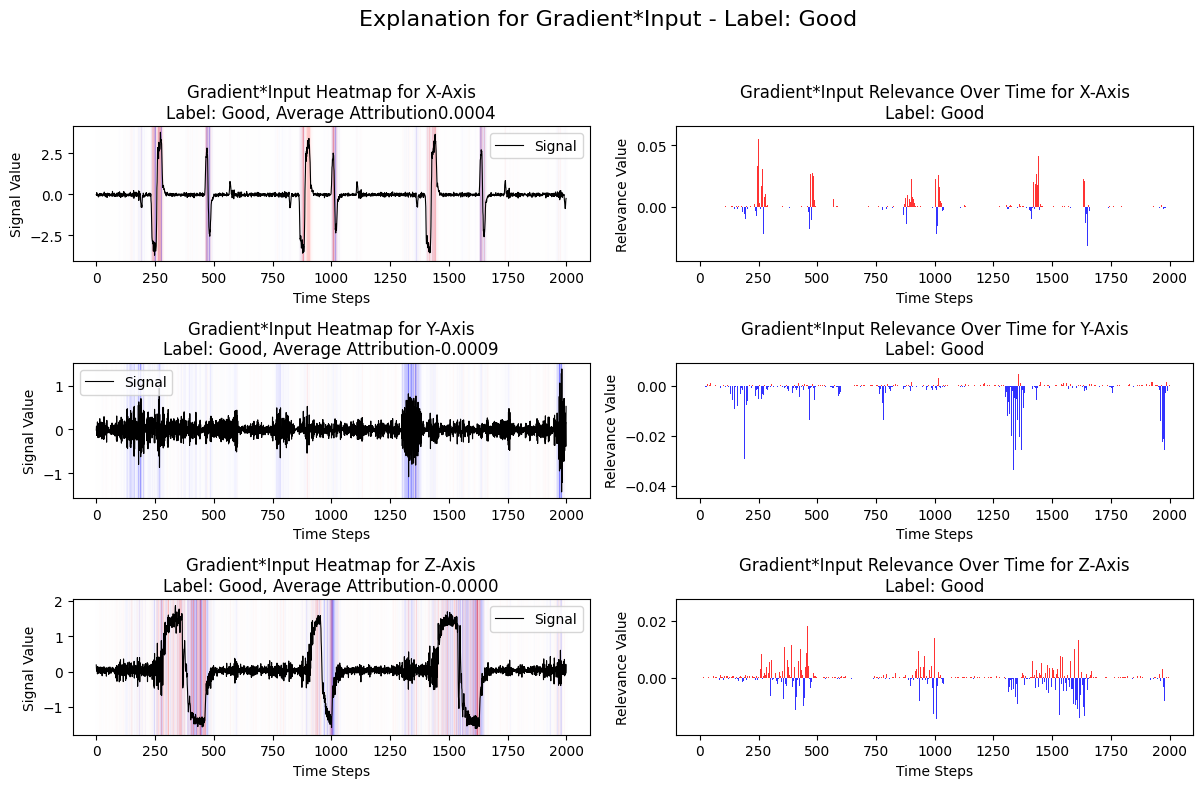

In [51]:
# Grad*Input
grad_input_attr, _ = grad_times_input_relevance(best_model, sample)

print(f"Min relevance: {np.min(grad_input_attr.detach().cpu().numpy())}, Max relevance: {np.max(grad_input_attr.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, grad_input_attr, label, "Gradient*Input")


In [52]:
# Example usage
summary_g = summarize_attributions(grad_input_attr.detach().cpu().numpy())  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_g = []
for axis, values in summary_g.items():
    row = {"Axis": axis}
    row.update(values)
    data_g.append(row)

# Create the DataFrame
df_summary_g = pd.DataFrame(data_g)

# Display the DataFrame as a table
print(df_summary_g)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            1037                  2.229959   
1  Axis 1             833                  0.240222   
2  Axis 2            1073                  1.539773   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.002150             963                 -1.364657   
1                    0.000288            1167                 -2.070596   
2                    0.001435             927                 -1.639238   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.001417                     0.865302   
1                   -0.001774                    -1.830374   
2                   -0.001768                    -0.099465   

   Average Relevance (Pos + Neg)  
0                       0.000433  
1                      -0.000915  
2                      -0.000050  


Min relevance: -0.0026131197810173035, Max relevance: 0.0018044853350147605
 Maximum Absolute Attribution in Axis 0: 0.0026131197810173035
 Maximum Absolute Attribution in Axis 1: 0.0011610653018578887
 Maximum Absolute Attribution in Axis 2: 0.0021121546160429716


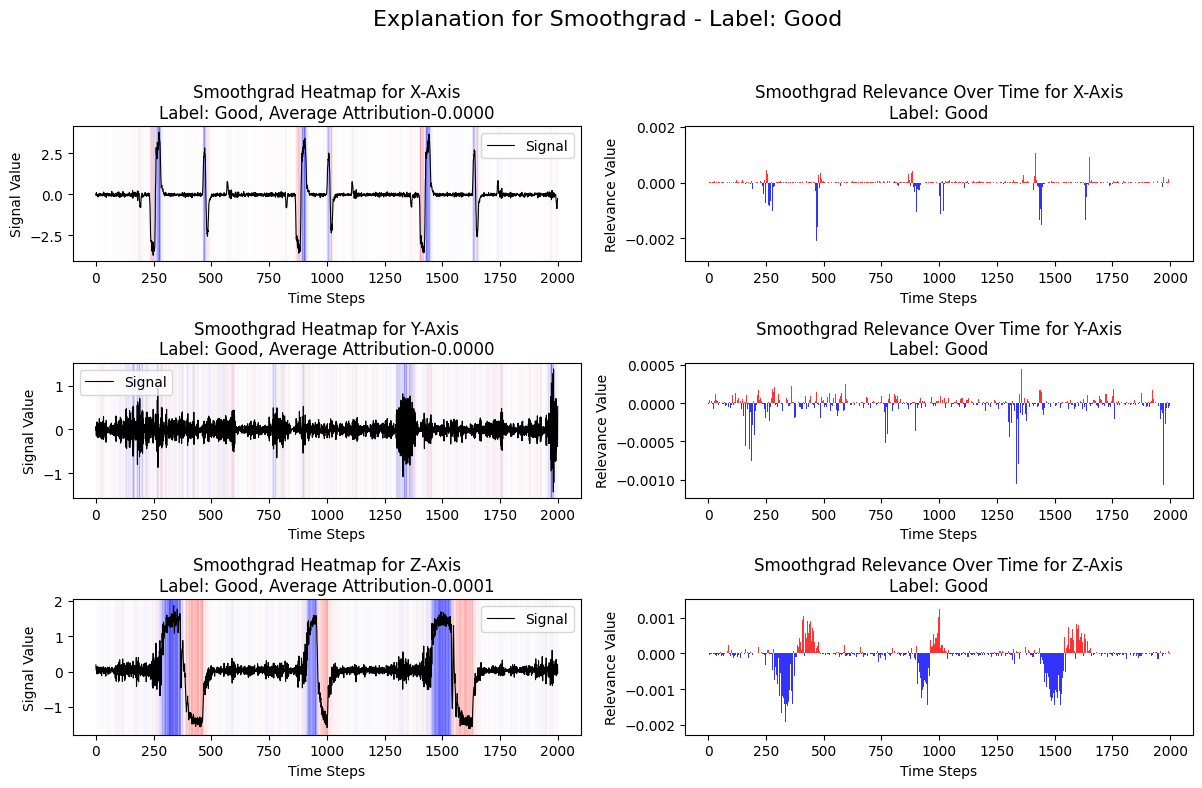

In [53]:

# SmoothGrad
smoothgrad_attr, _ = smoothgrad_relevance(best_model, sample)
print(f"Min relevance: {np.min(smoothgrad_attr.detach().cpu().numpy())}, Max relevance: {np.max(smoothgrad_attr.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, smoothgrad_attr, label, "Smoothgrad")


Min relevance: -0.014937400817871094, Max relevance: 0.02406144142150879
 Maximum Absolute Attribution in Axis 0: 0.02406144142150879
 Maximum Absolute Attribution in Axis 1: 0.014937400817871094
 Maximum Absolute Attribution in Axis 2: 0.006457090377807617


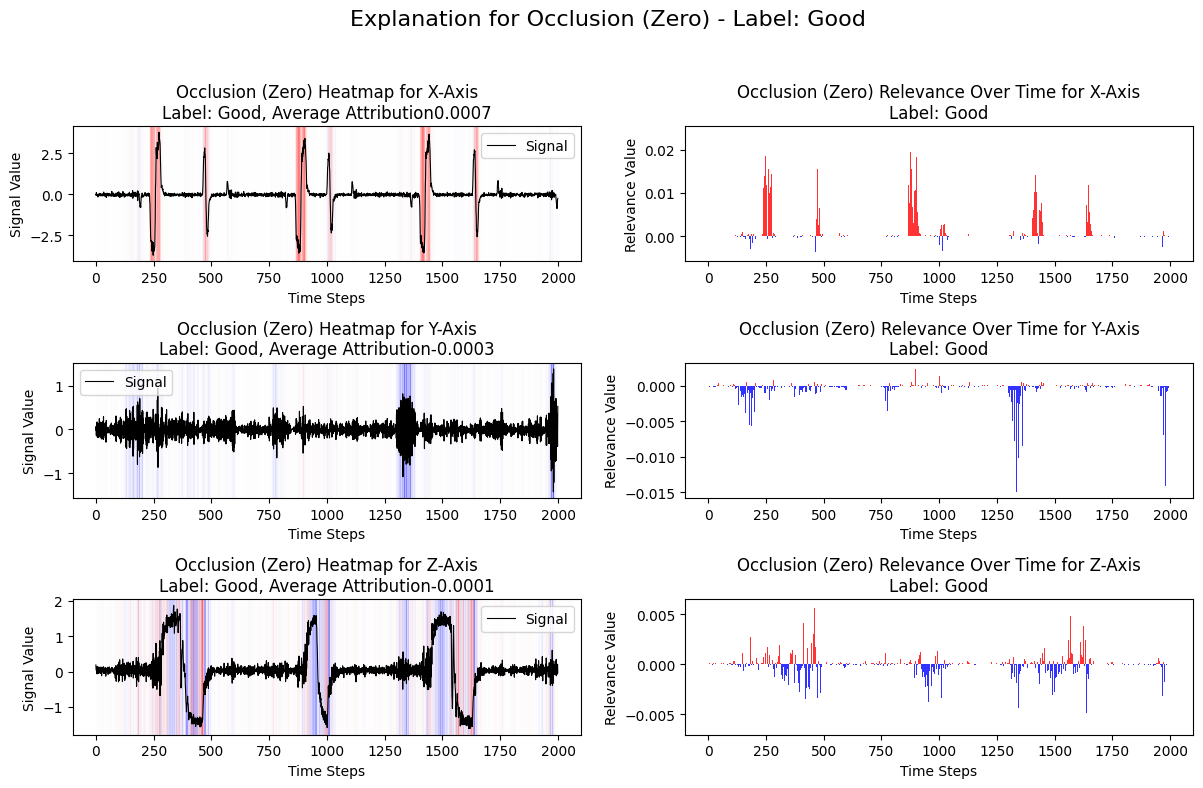

In [54]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero, _ = occlusion_signal_relevance(best_model, sample, occlusion_type="zero")
print(f"Min relevance: {np.min(occlusion_attr_zero.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, occlusion_attr_zero, label, "Occlusion (Zero)")


Min relevance: -0.1269242763519287, Max relevance: 0.05502510070800781
 Maximum Absolute Attribution in Axis 0: 0.1269242763519287
 Maximum Absolute Attribution in Axis 1: 0.1269242763519287
 Maximum Absolute Attribution in Axis 2: 0.1269242763519287


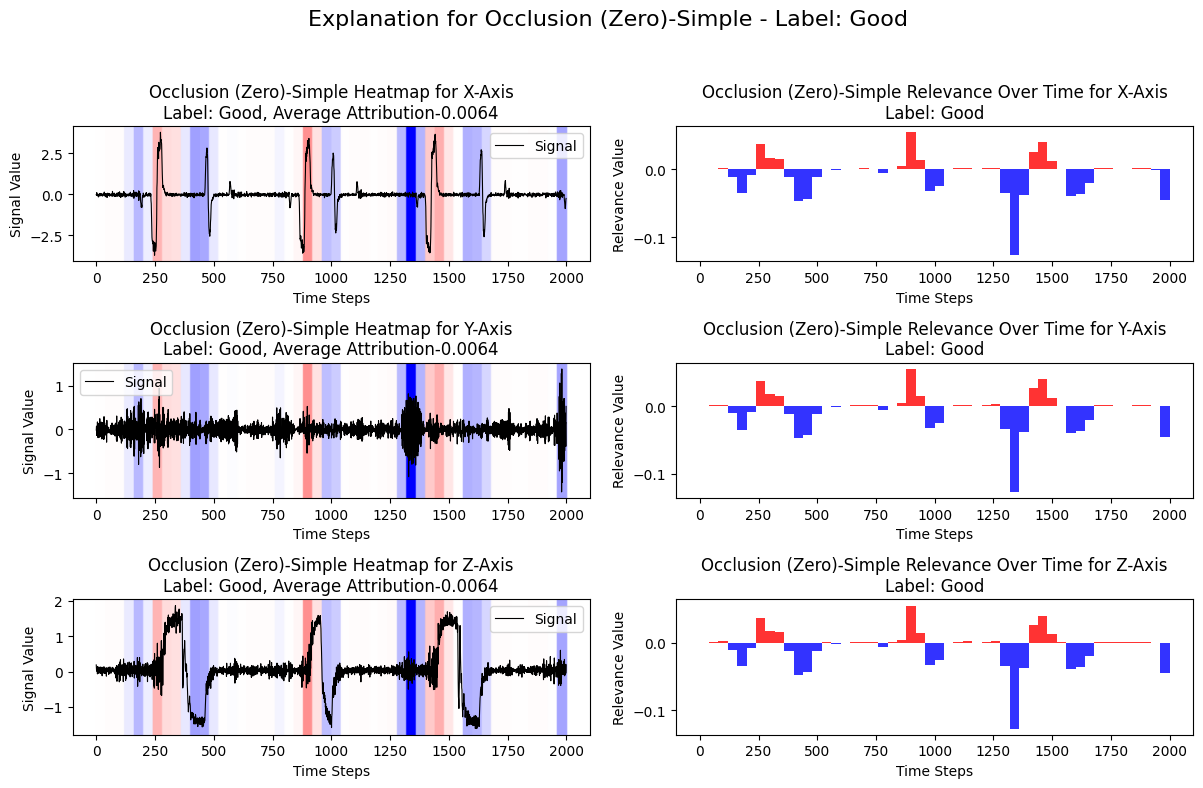

In [55]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero_simple, _ = occlusion_simpler_relevance(best_model, sample, occlusion_type="zero")
print(f"Min relevance: {np.min(occlusion_attr_zero_simple.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero_simple.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, occlusion_attr_zero_simple, label, "Occlusion (Zero)-Simple")


Min relevance: -0.06480622291564941, Max relevance: 0.10286998748779297
 Maximum Absolute Attribution in Axis 0: 0.10286998748779297
 Maximum Absolute Attribution in Axis 1: 0.10286998748779297
 Maximum Absolute Attribution in Axis 2: 0.10286998748779297


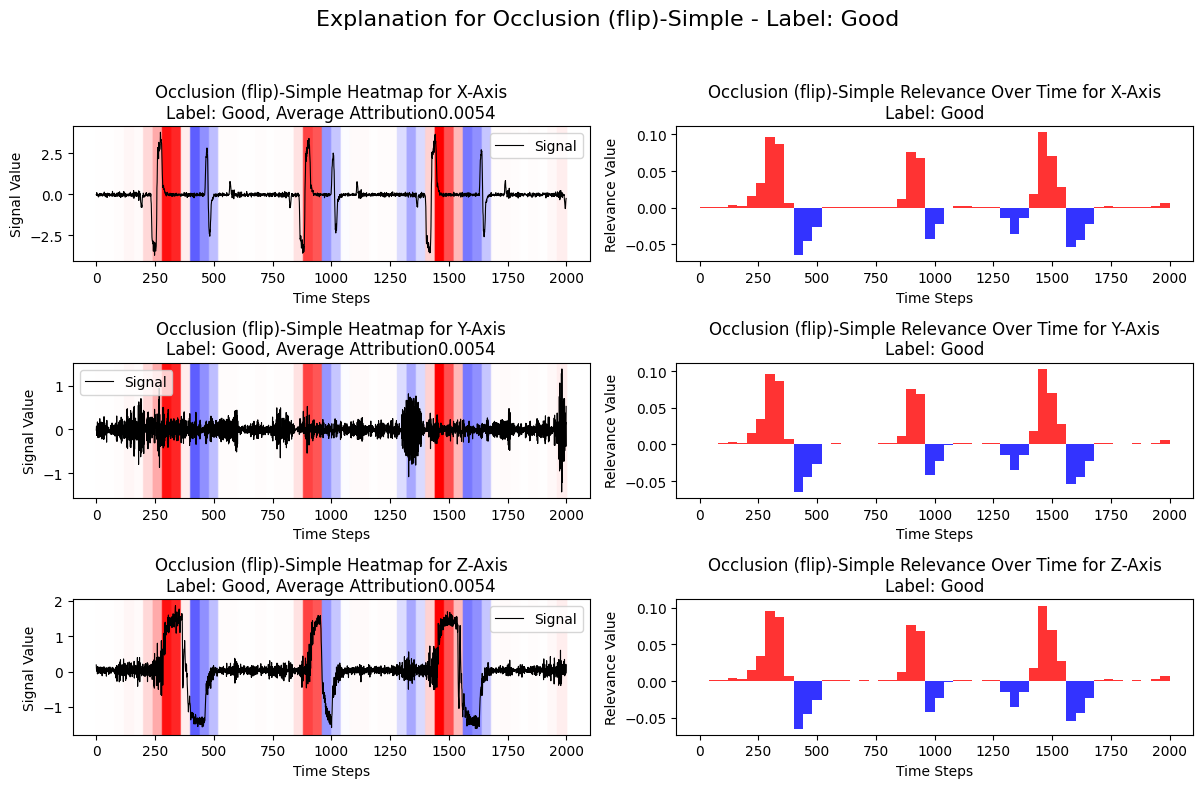

In [56]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero_simple, _ = occlusion_simpler_relevance(best_model, sample, occlusion_type="flip")
print(f"Min relevance: {np.min(occlusion_attr_zero_simple.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero_simple.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, occlusion_attr_zero_simple, label, "Occlusion (flip)-Simple")


Min relevance: -0.02457118034362793, Max relevance: 0.03264474868774414
 Maximum Absolute Attribution in Axis 0: 0.03264474868774414
 Maximum Absolute Attribution in Axis 1: 0.02457118034362793
 Maximum Absolute Attribution in Axis 2: 0.021828889846801758


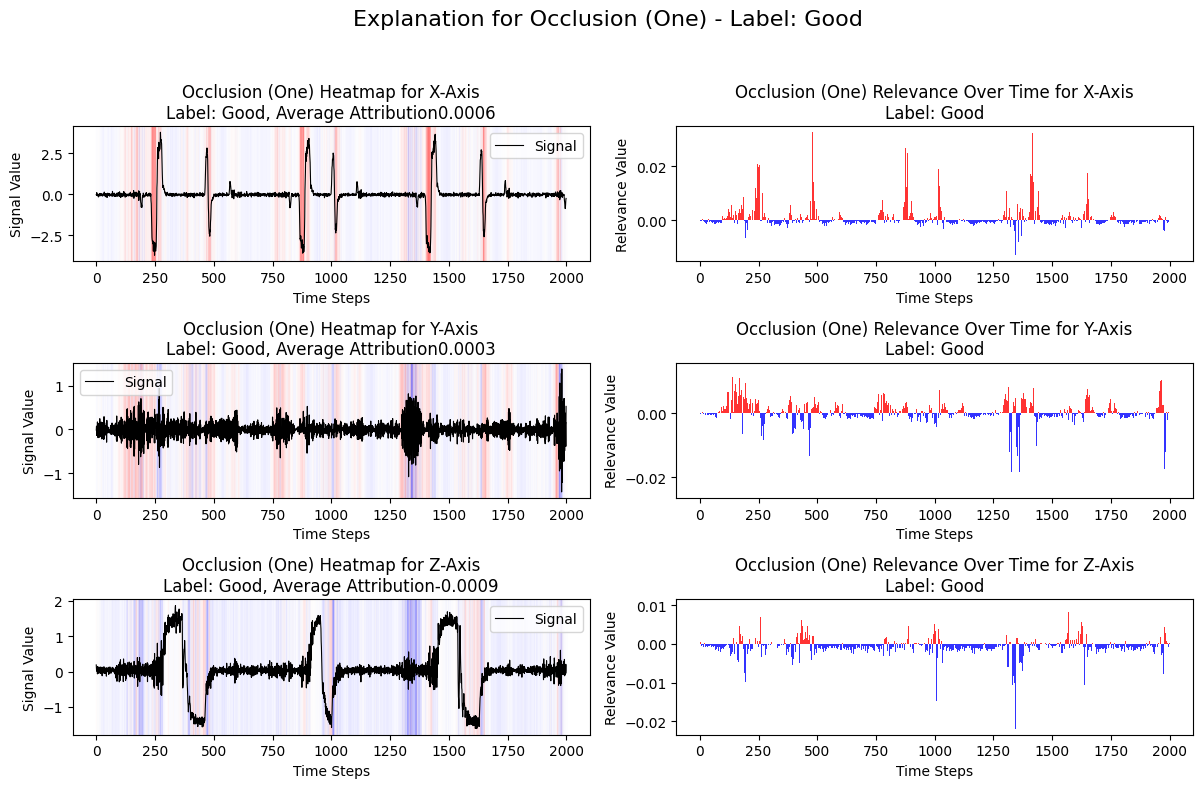

In [57]:
# Occlusion (one occlusion)
occlusion_attr_one, _ = occlusion_signal_relevance(best_model, sample, occlusion_type="one")
print(f"Min relevance: {np.min(occlusion_attr_one.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_one.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, occlusion_attr_one, label, "Occlusion (One)")


Min relevance: -0.030988693237304688, Max relevance: 0.028336524963378906
 Maximum Absolute Attribution in Axis 0: 0.028336524963378906
 Maximum Absolute Attribution in Axis 1: 0.030988693237304688
 Maximum Absolute Attribution in Axis 2: 0.014389753341674805


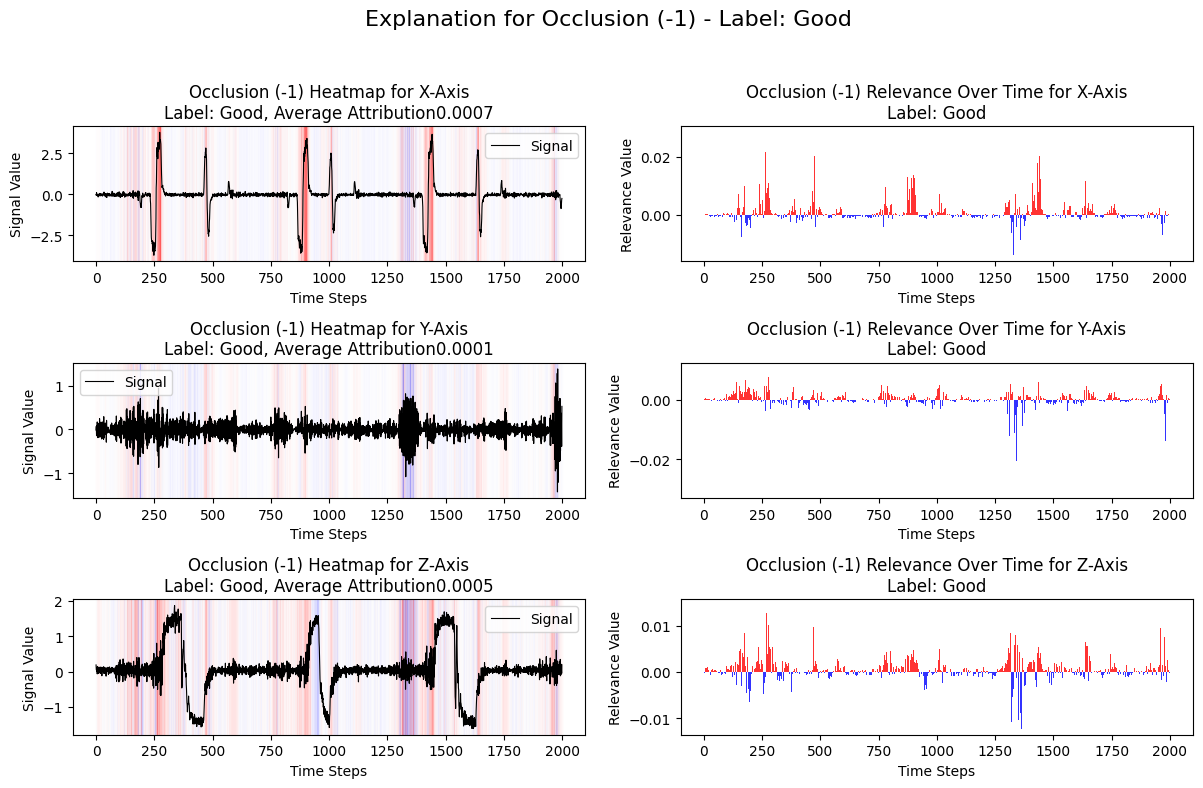

In [58]:
# Occlusion (-one occlusion)
occlusion_attr_mone, _ = occlusion_signal_relevance(best_model, sample, occlusion_type="mone")
print(f"Min relevance: {np.min(occlusion_attr_mone.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_mone.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, occlusion_attr_mone, label, "Occlusion (-1)")


Min relevance: -0.02879953384399414, Max relevance: 0.05103492736816406
 Maximum Absolute Attribution in Axis 0: 0.05103492736816406
 Maximum Absolute Attribution in Axis 1: 0.02879953384399414
 Maximum Absolute Attribution in Axis 2: 0.012738943099975586


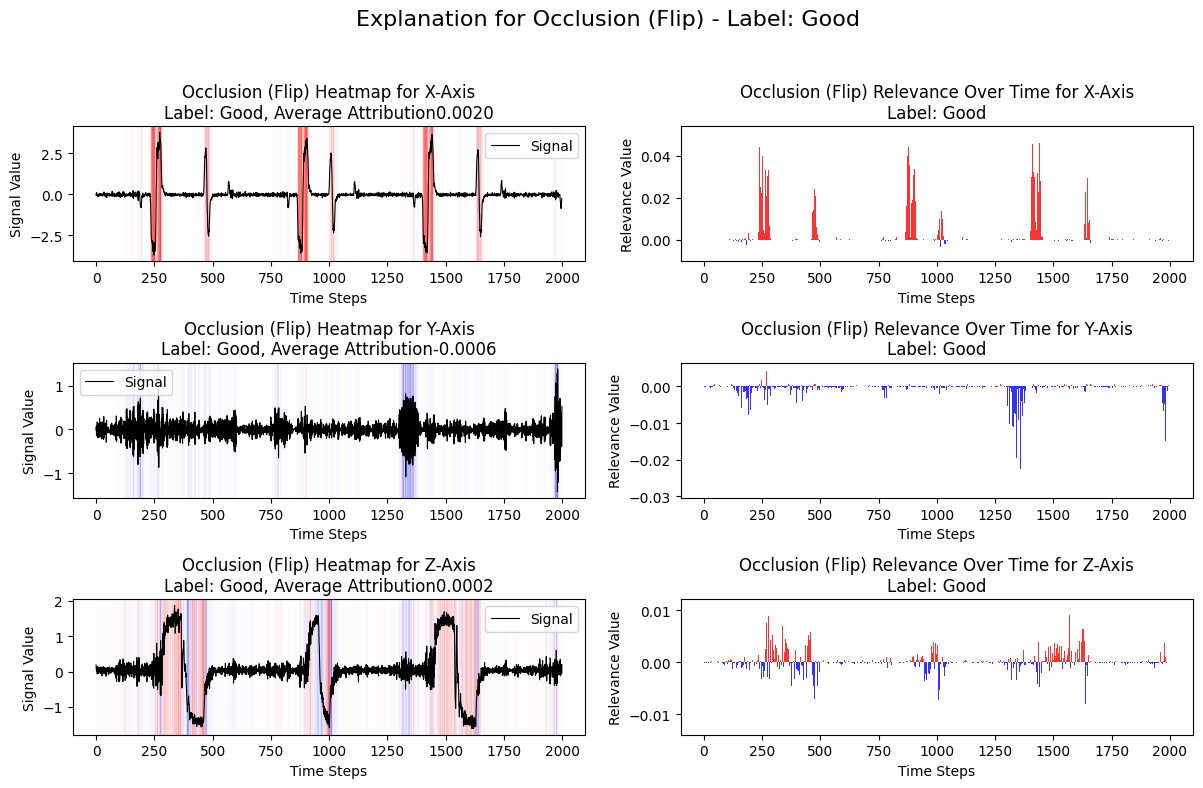

In [59]:
# Occlusion (flip occlusion)
occlusion_attr_flip, _ = occlusion_signal_relevance(best_model, sample, occlusion_type="flip")
print(f"Min relevance: {np.min(occlusion_attr_flip.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_flip.detach().cpu().numpy())}")

visualize_with_label_attribution(sample, occlusion_attr_flip, label, "Occlusion (Flip)")


In [41]:
# Load a Bad sample

# Load a batch
sample_batch, label_batch = next(iter(train_loader))

# Choose a random index
random_index_b = random.randint(0, len(sample_batch) - 1)

# Select the random sample and its corresponding label
sample_b = sample_batch[random_index_b]  # Shape: (3, 10000)
label_b = label_batch[random_index_b]    # Shape: ()



sample_b = sample_b.to(device)
label_b = label_b.to(device)

_, predicted_label_b = predict_single(best_model, sample_b)


# Print the selected sample and label
print(f"Random Index: {random_index_b}, Predicted_label:{predicted_label_b}, True_label:{label_b}")
print(sample_b,sample_b.shape)


Random Index: 21, Predicted_label:1, True_label:1
tensor([[ 0.1351, -0.0299,  0.0730,  ...,  0.1808, -0.0815,  0.0295],
        [ 1.3963,  1.4287,  2.0287,  ...,  0.6182, -0.1555, -0.4967],
        [ 0.3106, -0.4969,  0.1483,  ...,  0.0067, -1.0817,  1.2604]],
       device='cuda:0') torch.Size([3, 2000])


Sample device: cuda:0
Model device: cuda:0
Target device: cuda:0
Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
Sample 27 Label: Bad


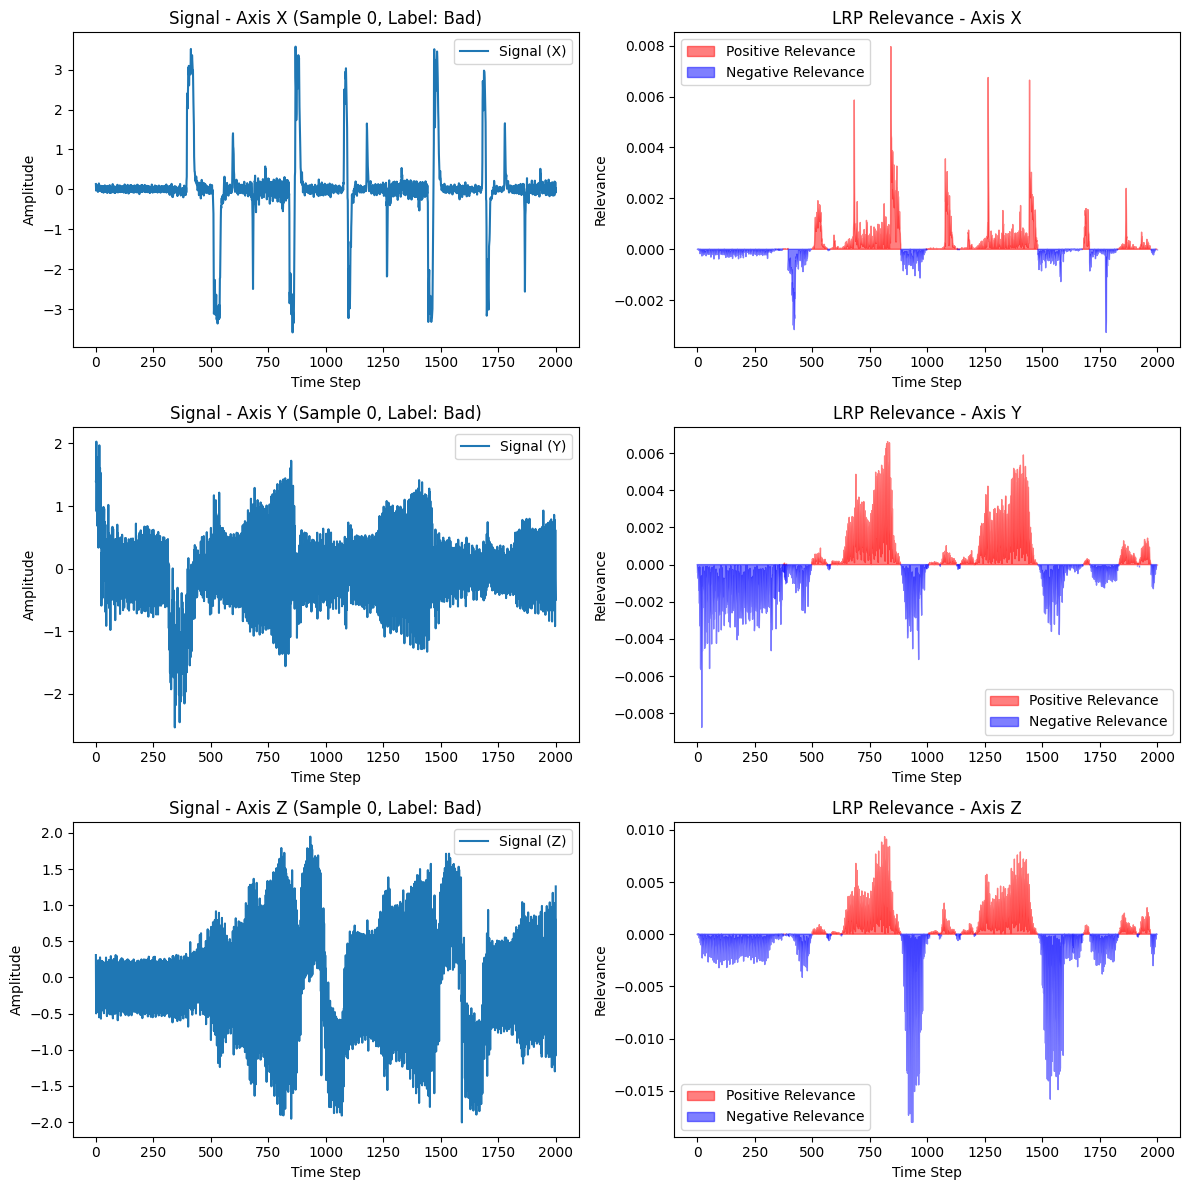

In [42]:
relevance_b, input_signal_b, final_label_b = compute_lrp_relevance(
    model=best_model,
    sample=sample_b,  # Shape: (3, 10000) or torch tensor
    label=label_b,  # Use true label or None for prediction
    device=device
)
print(f"Sample {random_index} Label: {'Good' if final_label_b == 0 else 'Bad'}")

# Visualize LRP relevances (use your existing `visualize_lrp_relevance_single_sample` function)
visualize_lrp_single_sample(
    signal=input_signal_b,
    relevance=relevance_b,
    label=final_label_b)

In [ ]:
# Grad*Input
grad_input_attr_b, _ = grad_times_input_relevance(best_model, sample_b)
print(f"Min relevance: {np.min(grad_input_attr_b.detach().cpu().numpy())}, Max relevance: {np.max(grad_input_attr_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, grad_input_attr_b, label_b, "Gradient*Input")

In [ ]:
# Example usage
summary_b_g = summarize_attributions(grad_input_attr_b.detach().cpu().numpy())  # Pass your attributions here

# Flatten the summary dictionary and create a DataFrame
data_b_g = []
for axis, values in summary_b_g.items():
    row = {"Axis": axis}
    row.update(values)
    data_b_g.append(row)

# Create the DataFrame
df_summary_b_g = pd.DataFrame(data_b_g)

# Display the DataFrame as a table
print(df_summary_b_g)


In [ ]:
# SmoothGrad
smoothgrad_attr_b, _ = smoothgrad_relevance(model, sample_b)
print(f"Min relevance: {np.min(smoothgrad_attr_b.detach().cpu().numpy())}, Max relevance: {np.max(smoothgrad_attr_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, smoothgrad_attr_b, label_b, "Smoothgrad")


In [ ]:
# Example usage
summary_b_sg = summarize_attributions(smoothgrad_attr_b.detach().cpu().numpy())  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_b_sg = []
for axis, values in summary_b_sg.items():
    row = {"Axis": axis}
    row.update(values)
    data_b_sg.append(row)

# Create the DataFrame
df_summary_b_sg = pd.DataFrame(data_b_sg)

# Display the DataFrame as a table
print(df_summary_b_sg)# Flatten the summary dictionary and create a DataFrame


In [ ]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero_b, _ = occlusion_signal_relevance(model, sample_b, occlusion_type="zero")
print(f"Min relevance: {np.min(occlusion_attr_zero_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, occlusion_attr_zero_b, label_b, "Occlusion (Zero)")

In [ ]:
# Occlusion (one occlusion)
occlusion_attr_one_b, _ = occlusion_signal_relevance(model, sample_b, occlusion_type="one")
print(f"Min relevance: {np.min(occlusion_attr_one_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_one_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, occlusion_attr_one_b, label_b, "Occlusion (One)")

In [ ]:
# Occlusion (-one occlusion)
occlusion_attr_mone_b, _ = occlusion_signal_relevance(model, sample_b, occlusion_type="mone")
print(f"Min relevance: {np.min(occlusion_attr_mone_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_mone_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, occlusion_attr_mone_b, label_b, "Occlusion (-1)")

In [ ]:

# Occlusion (e.g., zero-based occlusion)
occlusion_attr_flip_b, _ = occlusion_signal_relevance(model, sample_b, occlusion_type="flip")
print(f"Min relevance: {np.min(occlusion_attr_flip_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_flip_b.detach().cpu().numpy())}")

visualize_with_label_attribution(sample_b, occlusion_attr_flip_b, label_b, "Occlusion (Flip)")


In [ ]:
summary_b_of = summarize_attributions(occlusion_attr_flip_b.detach().cpu().numpy())  # Pass your attributions here

# Flatten the summary dictionary and create a DataFrame
data = []
for axis, values in summary_b_of.items():
    row = {"Axis": axis}
    row.update(values)
    data.append(row)

# Create the DataFrame
df_summary = pd.DataFrame(data)

# Display the DataFrame as a table
print(df_summary)

In [ ]:
relevance_b, input_signal_b, final_label_b = compute_lrp_relevance(
    model=model,
    sample=sample_b,  # Shape: (3, 10000) or torch tensor
    label=label_b,  # Use true label or None for prediction
    device=device
)
print(f"Sample {random_index_b} Label: {'Good' if final_label_b == 0 else 'Bad'}")

# Visualize LRP relevances (use your existing `visualize_lrp_relevance_single_sample` function)
visualize_lrp_single_sample(
    signal=input_signal_b,
    relevance=relevance_b,
    label=final_label_b)

In [ ]:

print(f"Min relevance: {np.min(relevance_b)}, Max relevance: {np.max(relevance_b)}")
visualize_with_label_attribution(sample_b, relevance_b, label_b, "LRP")


In [ ]:
relevance_time_b, relevance_freq_b, signal_freq_b, input_signal_b, freqs_b, predicted_label_b = compute_dft_lrp_relevance(
        model=model,
        sample=sample_b.cpu().detach().numpy(),  # Convert to NumPy for DFTLRP
        label=label_b.item(),
        device=device,
        signal_length=2000,
        sampling_rate=400  # Placeholder, replace with your actual sampling rate
    )

In [ ]:
# Visualize the results
visualize_lrp_dft(
        relevance_time=relevance_time_b,
        relevance_freq=relevance_freq_b,
        signal_freq=signal_freq_b,
        input_signal=input_signal_b,
        freqs=freqs_b,
        predicted_label=predicted_label_b,
        k_max=1000,  # Plot up to 1000 Hz
        sampling_rate=400  # Placeholder, replace with your actual sampling rate
    )

In [ ]:
summary_b_lrp = summarize_attributions( relevance_freq_b)  # Pass your attributions here

# Flatten the summary dictionary and create a DataFrame
data_lrp = []
for axis, values in summary_b_lrp.items():
    row = {"Axis": axis}
    row.update(values)
    data_lrp.append(row)

# Create the DataFrame
df_summary_lrp = pd.DataFrame(data_lrp)

# Display the DataFrame as a table
print(df_summary_lrp)